<a href="https://colab.research.google.com/github/dangcaptkd2/Attention-ImageCaptioningWith-Pytorch/blob/son/Alexnet_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/dangcaptkd2/Fruits-Classification

Cloning into 'Fruits-Classification'...
remote: Enumerating objects: 2565, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 2565 (delta 1), reused 14 (delta 1), pack-reused 2548
Receiving objects: 100% (2565/2565), 6.53 GiB | 36.30 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Checking out files: 100% (2521/2521), done.


In [2]:
#checking files 
import os 
path_apple = '/content/Fruits-Classification/data/apple'
path_banana = '/content/Fruits-Classification/data/pear'
apple_imgs = os.listdir(path_apple)
banana_imgs = os.listdir(path_banana)
#len(apple_imgs)

In [3]:
# Downloading model AlexNet
import torch
model = torch.hub.load('pytorch/vision:v0.9.0', 'alexnet', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [4]:
# remove 2FC layers
from torch import nn
from collections import OrderedDict
for param in model.parameters():
    param.requires_grad = False
classifier = nn.Sequential(OrderedDict([('fc1', nn.Dropout(p=0.5)),
                                         ('linear', nn.Linear(9216,4096)),
                                         ('relu',nn.ReLU())]))

model.classifier = classifier
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Dropout(p=0.5, inplace=False)
    (linear): Linear(in_features=9216, out_features=4096, bias=

In [5]:
#preprocess
from torchvision import transforms
from PIL import Image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
#prepare data train
data_train = []
label_train = []
for ix in apple_imgs :
    img = Image.open(path_apple+"/"+ix)
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0) 
    res = model(input_batch)
    data_train.append(res)
    label_train.append('1')
for iy in banana_imgs :
    img = Image.open(path_banana+"/"+iy)
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0) 
    res = model(input_batch)
    data_train.append(res)
    label_train.append('0')

In [7]:
#convert to numpy 1d array 
for i in range(len(data_train)):
 data_train[i] = torch.detach(data_train[i]).numpy()
for i in range(len(data_train)):
 data_train[i] = data_train[i].reshape(4096)

In [8]:
#split 3 train 7 test
from sklearn.model_selection import train_test_split
x_train , x_val , y_train , y_val = train_test_split(data_train,label_train,test_size=0.7,random_state=0)

In [9]:
#evaluate
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svc = SVC(random_state=42)
svc.fit(x_train,y_train)
predict = svc.predict(x_val)
acc_score = accuracy_score(y_val,predict)
print(acc_score)

0.9657142857142857


In [10]:
# precision recall f1 score
from sklearn.metrics import classification_report
target_names = ['apple', 'pear']
print(classification_report(y_val,predict, target_names=target_names))

              precision    recall  f1-score   support

       apple       0.94      0.99      0.97       174
        pear       0.99      0.94      0.96       176

    accuracy                           0.97       350
   macro avg       0.97      0.97      0.97       350
weighted avg       0.97      0.97      0.97       350



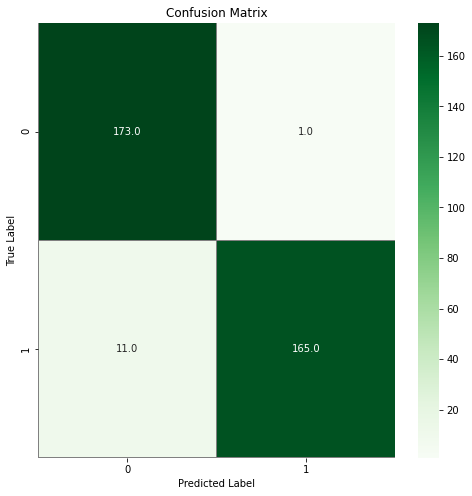

In [11]:
# compute the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_val, predict) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [23]:
#encode with fc2 Alexnet
model_fc2 = torch.hub.load('pytorch/vision:v0.9.0', 'alexnet', pretrained=True)
model_fc2.eval()
classifier_fc2 = nn.Sequential(OrderedDict([('fc1', nn.Dropout(p=0.5)),
                                         ('linear', nn.Linear(9216,4096)),
                                         ('relu',nn.ReLU()),
                                          ('dropout',nn.Dropout(p=0.5)),
                                          ('linear2',nn.Linear(4096,4096)),
                                          ('relu2',nn.ReLU())]))
model_fc2.classifier = classifier_fc2
model_fc2.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Dropout(p=0.5, inplace=False)
    (linear): Linear(in_features=9216, out_features=4096, bias=

In [24]:
# do the same fc1
data_train_fc2 = []
label_train_fc2 = []
for ix in apple_imgs :
    img = Image.open(path_apple+"/"+ix)
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0) 
    res = model_fc2(input_batch)
    data_train_fc2.append(res)
    label_train_fc2.append('1')
for iy in banana_imgs :
    img = Image.open(path_banana+"/"+iy)
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0) 
    res = model_fc2(input_batch)
    data_train_fc2.append(res)
    label_train_fc2.append('0')

In [25]:
for i in range(len(data_train_fc2)):
 data_train_fc2[i] = torch.detach(data_train_fc2[i]).numpy()
for i in range(len(data_train_fc2)):
 data_train_fc2[i] = data_train_fc2[i].reshape(4096)

In [26]:
data_train[1] 

array([1.7524608 , 0.7033226 , 0.05674529, ..., 0.        , 0.        ,
       0.62914664], dtype=float32)

In [28]:
data_train_fc2[1]

array([0.5069691 , 0.        , 0.00791701, ..., 0.06361172, 0.24325399,
       0.12719294], dtype=float32)

In [29]:
x_train , x_val , y_train , y_val = train_test_split(data_train_fc2,label_train_fc2,test_size=0.7,random_state=0)

In [30]:
svc_fc2 = SVC(random_state=42)
svc_fc2.fit(x_train,y_train)
predict_fc2 = svc_fc2.predict(x_val)
acc_score_fc2 = accuracy_score(y_val,predict_fc2)
print(acc_score_fc2)
target_names = ['apple', 'pear']
print(classification_report(y_val,predict_fc2, target_names=target_names))

0.9714285714285714
              precision    recall  f1-score   support

       apple       0.95      1.00      0.97       174
        pear       1.00      0.94      0.97       176

    accuracy                           0.97       350
   macro avg       0.97      0.97      0.97       350
weighted avg       0.97      0.97      0.97       350



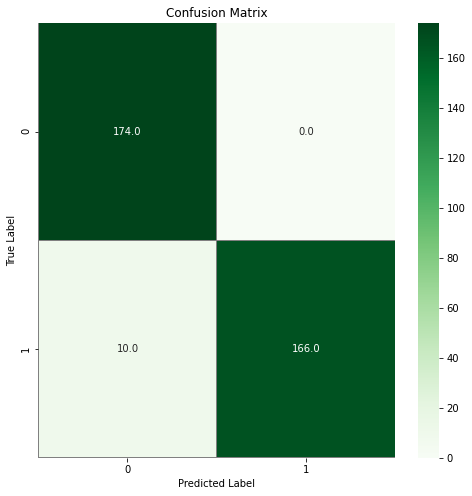

In [31]:
# the same result
confusion_mtx = confusion_matrix(y_val, predict_fc2) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
img = Image.open('/content/Fruits-Classification/data/banana/banana_0.jpg')
input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0) 
res = model(input_batch)

In [ ]:
res = torch.detach(res).numpy()
#res = res.reshape(4096)
res.shape

(1, 4096)

In [ ]:
svc.predict(res)

array(['0'], dtype='<U1')